### 3. Unsupervised learning

In [2]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [3]:
train_df = pd.read_csv('./train.dat', sep='\t')
test_df = pd.read_csv('./test.dat', sep='\t')

In [4]:
x_train = train_df[train_df.columns[:-2]]
y_train = train_df[train_df.columns[-1]].astype(int)
x_test = test_df[test_df.columns[:-2]]
y_test = test_df[test_df.columns[-1]].astype(int)

### PCA

Explained Variance Ratio: [0.3276674  0.20275488 0.16800257 0.11377286 0.09260178 0.03750715
 0.02864041 0.02099547 0.00805747]


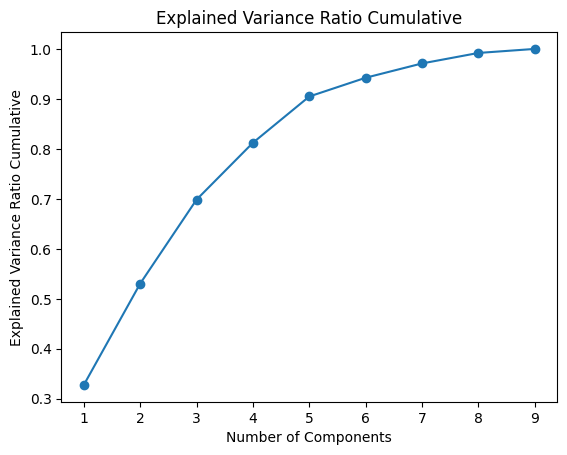

In [5]:
# hacemos PCA con el x_train
pca = PCA()
pca.fit_transform(x_train)

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

# Visualización de la varianza explicada acumulada
plt.figure()
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio Cumulative')
plt.title('Explained Variance Ratio Cumulative')
plt.show()

En  la curva de varianza se puede observar que a partir de 6 componentes el cambio se reduce mucho, por lo que voy a tomar pca con 6 componentes

In [6]:
pca = PCA(n_components=6) 

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.fit_transform(x_test)

df_pca = pd.DataFrame(x_train_pca, columns=[f'Componente {i}' for i in range(1, 7)])

# Añadir las etiquetas de clase a df_pca
df_pca['Clase'] = y_train

# Crear un gráfico de pares
sns.pairplot(df_pca, hue='Clase', palette='viridis')
plt.suptitle('Gráfico de Pares de Componentes Principales (PCA)')
plt.show()

In [7]:
classifier = LogisticRegression(penalty='l2', C=0.01, solver='saga')
classifier.fit(x_train_pca, y_train)
y_pred = classifier.predict(x_test_pca)

print(accuracy_score(y_test, y_pred))

0.34285714285714286


### CLUSTERING: K-MEANS

In [8]:
k_range = range(2, 6)

fig, axes = plt.subplots(nrows=len(k_range), ncols=1, figsize=(10, 6 * len(k_range)))

for i, k in enumerate(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    kmeans.fit(x_train_pca)
    
    cluster_labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    
    axes[i].scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
    axes[i].scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=100)  # Centroides
    axes[i].set_xlabel('Componente Principal 1')
    axes[i].set_ylabel('Componente Principal 2')
    axes[i].set_title(f'Resultados de Clustering con {k} clusters después de PCA')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

Viendo esto parece apropiado separar los datos en 2 o 3 clusters, donde son claramante diferenciables. Ya que al aumentar el numero de clusters estos se superponen

### CLUSTERING: SPECTRAL CLUSTERING

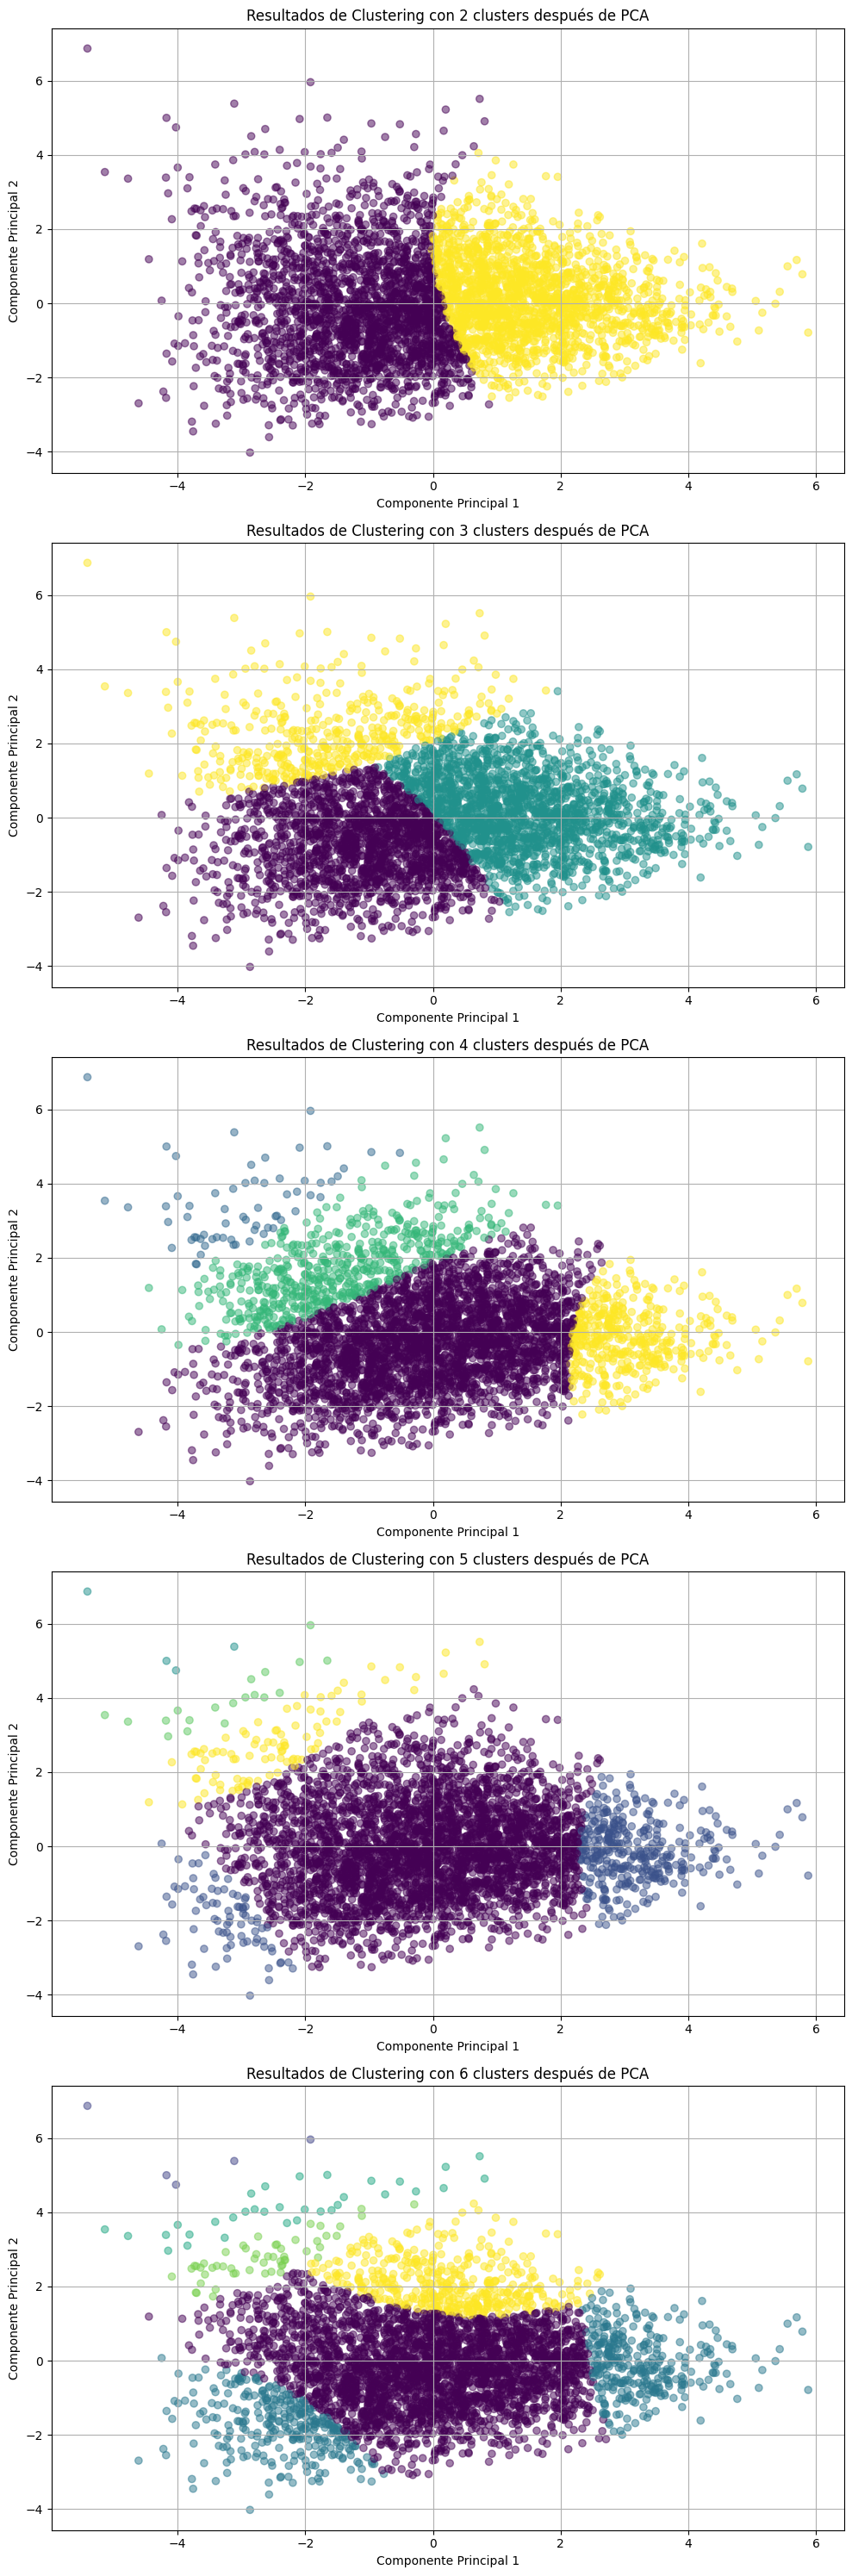

In [9]:
k_range = range(2, 7)

fig, axes = plt.subplots(nrows=len(k_range), ncols=1, figsize=(10, 6 * len(k_range)))

for i, k in enumerate(k_range):
    spectral_clustering = SpectralClustering(n_clusters=k, random_state=42)
    spectral_clustering.fit(x_train_pca[:, [0,1]])
    cluster_labels = spectral_clustering.labels_
    
    axes[i].scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
    axes[i].set_xlabel('Componente Principal 1')
    axes[i].set_ylabel('Componente Principal 2')
    axes[i].set_title(f'Resultados de Clustering con {k} clusters después de PCA')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

### CLUSTERING VS CLASIFICACIÓN

En este caso he decidido poner a prueba ambos tipos de clusterings como clasificadores para observar el resultado

              precision    recall  f1-score   support

           0       0.66      0.77      0.71      2035
           1       0.73      0.62      0.67      2062

    accuracy                           0.69      4097
   macro avg       0.70      0.69      0.69      4097
weighted avg       0.70      0.69      0.69      4097



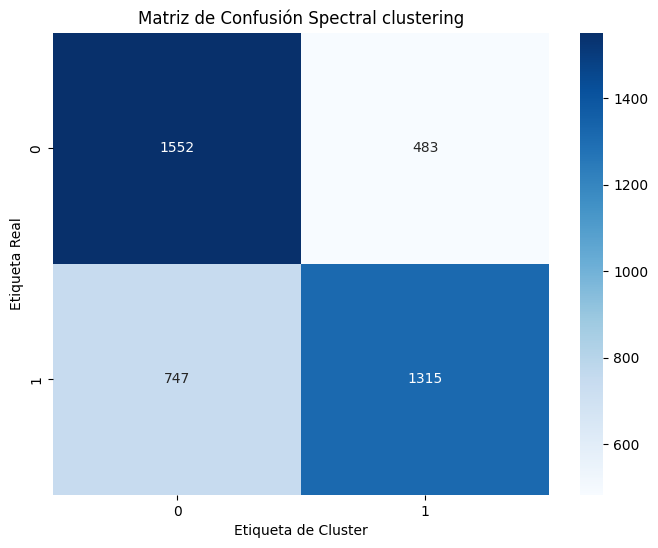

              precision    recall  f1-score   support

           0       0.68      0.76      0.72      2035
           1       0.73      0.64      0.68      2062

    accuracy                           0.70      4097
   macro avg       0.70      0.70      0.70      4097
weighted avg       0.70      0.70      0.70      4097



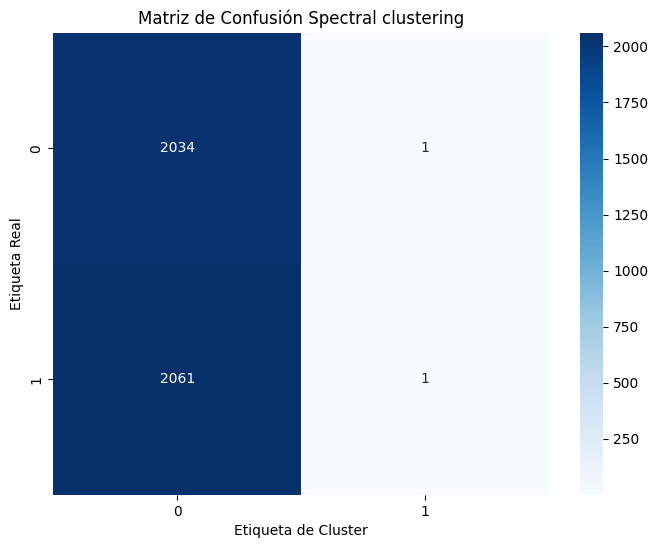

              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2035
           1       0.50      0.00      0.00      2062

    accuracy                           0.50      4097
   macro avg       0.50      0.50      0.33      4097
weighted avg       0.50      0.50      0.33      4097



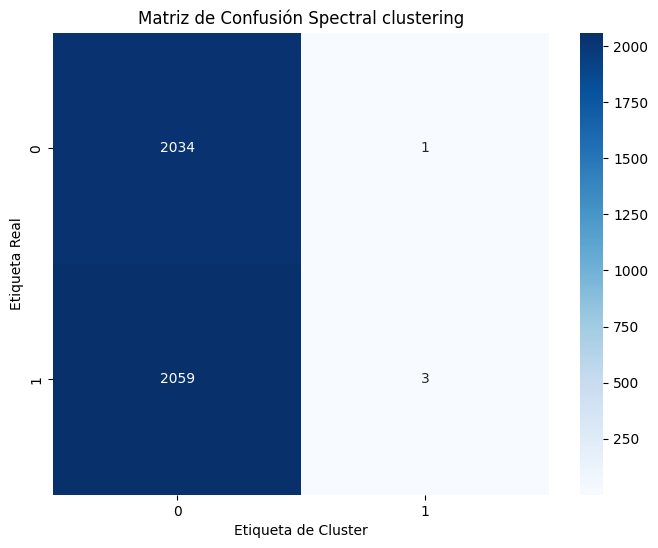

              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2035
           1       0.75      0.00      0.00      2062

    accuracy                           0.50      4097
   macro avg       0.62      0.50      0.33      4097
weighted avg       0.62      0.50      0.33      4097



In [10]:
datos = []
for dat in range(4):
    spectral_clustering = SpectralClustering(n_clusters=2, random_state=42)
    datos.append(dat)
    cluster_labels = spectral_clustering.fit_predict(x_train_pca[:, datos])

    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_train, cluster_labels)

    # Crear un heatmap de la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Etiqueta de Cluster')
    plt.ylabel('Etiqueta Real')
    plt.title('Matriz de Confusión Spectral clustering')
    plt.show()
    
    # Imprimir el reporte de clasificación
    print(classification_report(y_train, cluster_labels))

En el caso del spectral clustering los resultados no son demasiado buenos, teniendo muy mal desempeño en la etiqueta '0'

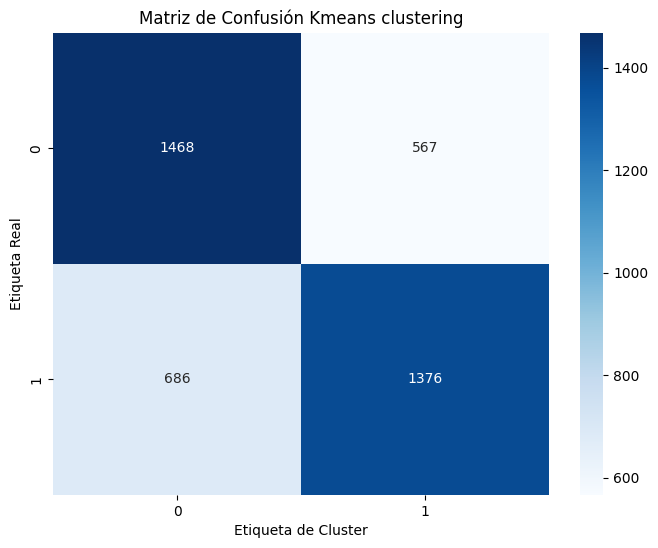

              precision    recall  f1-score   support

           0       0.68      0.72      0.70      2035
           1       0.71      0.67      0.69      2062

    accuracy                           0.69      4097
   macro avg       0.69      0.69      0.69      4097
weighted avg       0.69      0.69      0.69      4097



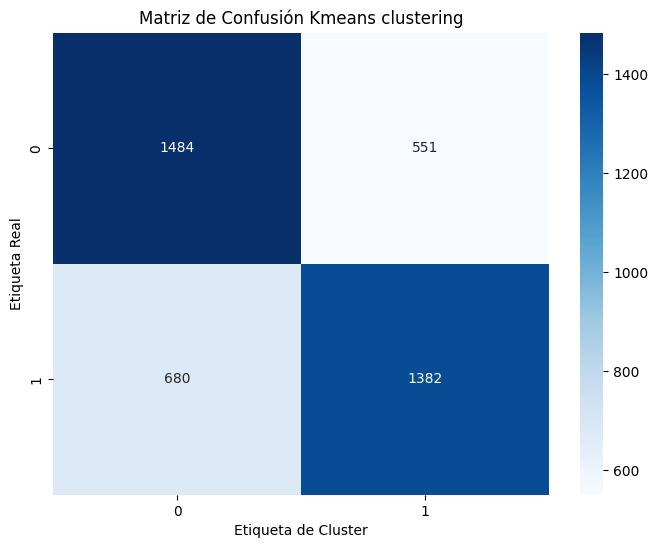

              precision    recall  f1-score   support

           0       0.69      0.73      0.71      2035
           1       0.71      0.67      0.69      2062

    accuracy                           0.70      4097
   macro avg       0.70      0.70      0.70      4097
weighted avg       0.70      0.70      0.70      4097



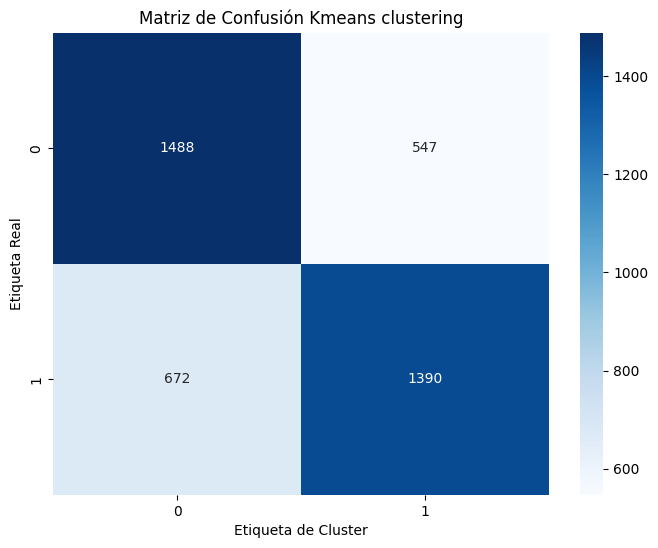

              precision    recall  f1-score   support

           0       0.69      0.73      0.71      2035
           1       0.72      0.67      0.70      2062

    accuracy                           0.70      4097
   macro avg       0.70      0.70      0.70      4097
weighted avg       0.70      0.70      0.70      4097



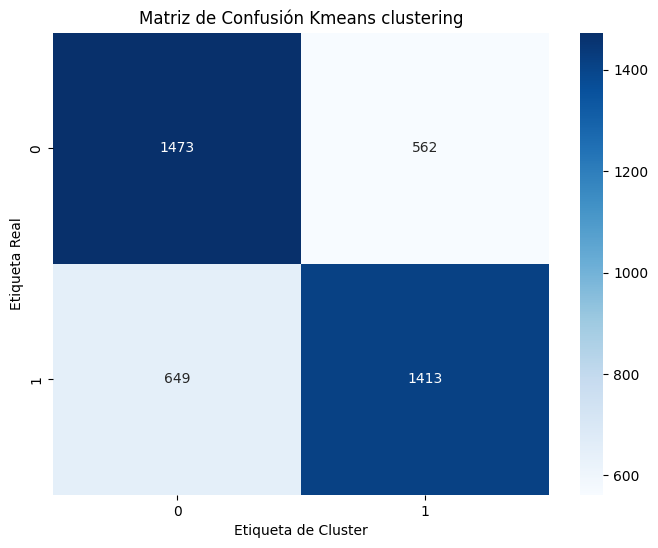

              precision    recall  f1-score   support

           0       0.69      0.72      0.71      2035
           1       0.72      0.69      0.70      2062

    accuracy                           0.70      4097
   macro avg       0.70      0.70      0.70      4097
weighted avg       0.70      0.70      0.70      4097



In [11]:
datos = []
for dat in range(4):
    # Inicializar el algoritmo de clustering con n_clusters=2
    kmeans = KMeans(n_clusters=2, random_state=42)

    datos.append(dat)
    cluster_labels = kmeans.fit_predict(x_train_pca[:, datos])

    # Mapear las etiquetas predichas
    cluster_labels_mapped = [1 if label == 0 else 0 for label in cluster_labels]

    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_train, cluster_labels_mapped)

    # Crear un heatmap de la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Etiqueta de Cluster')
    plt.ylabel('Etiqueta Real')
    plt.title('Matriz de Confusión Kmeans clustering')
    plt.show()

    print(classification_report(y_train, cluster_labels_mapped))

#### Los resultados para el algoritmo de clustering kmeans me parecen sorprendemente buenos, sobre todo teniendo en cuenta que estos se entrenan sin 'target variable' es decir con ausencia de información importante 